>> model loaded: protocol_4-21-0.0745_0.001.hdf5
>>>> evaluating on 'protocol_4'
Found 30240 images belonging to 2 classes.
Found 56160 images belonging to 2 classes.
                  pred_fake(0)   pred_real(1)
actural_fake(0)           36565            875
actual_real(1)             438          18282

<class 'numpy.ndarray'>
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False

EER: 0.0285	HTER: 0.0234
>> finished


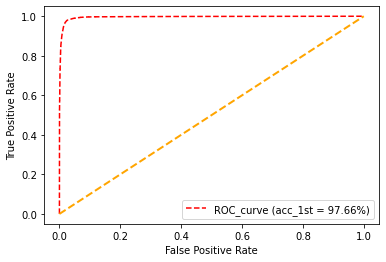

<Figure size 432x288 with 0 Axes>

In [1]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    trainDB = 'protocol_4'
    testDB = 'protocol_4'
    
    dataDir = 'F:\\Face_Database\\B-Database'
    modelPath = 'C:\\Users\\prlab\\Desktop\\ysg\\train_result\\densenet\\prfasd\\protocol_4-21-0.0745_0.001.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluating EER '''
    y_true = val_generator.classes
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5
    print('=======================')
    np.set_printoptions(threshold=sys.maxsize)
    print(type(y_pred))
    print(y_pred)
    print('=======================')

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()

In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3471210663005174111
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6663627080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11236302269799175603
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
